**NdLinear**

In this notebook, we are going to compare three models following the Batch Normalization paper experiment:
* Batch Normalization model: 3 hidden linear layers with batch normalizations.
* Base model: 3 hidden linear layers.
* NdLinear: 2 hidden NdLinear layers and one flattened linear layer.

We will be using the MNIST dataset.

In [1]:
!pip install ndlinear

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
!pip install python-mnist
!pip install torchsummary


5


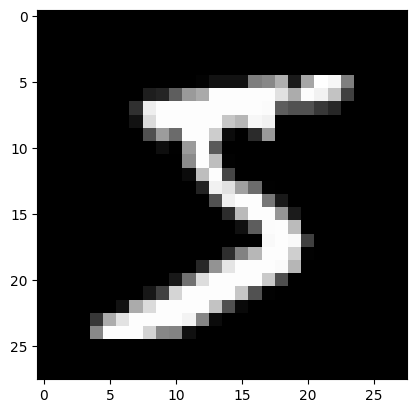

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from keras.datasets import mnist
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchsummary import summary
from ndlinear import NdLinear
import time

#load mnist data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.imshow(train_images[0], cmap='gray')
print(train_labels[0])

# Set seed
seed = 42
torch.manual_seed(seed)

# If using CUDA (GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Set Batch normalization model

# Training parameters
batch_size = 60
epochs = 50

# Create tensors and normalize data
train_images = torch.tensor(train_images / 255.0, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_images = torch.tensor(test_images / 255.0, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create Model
model_BN = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features = 28*28, out_features = 100),
    torch.nn.BatchNorm1d(num_features=100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features = 100, out_features = 100),
    torch.nn.BatchNorm1d(num_features=100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features = 100, out_features = 100),
    torch.nn.BatchNorm1d(num_features=100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features = 100, out_features = 10),
)
model_BN = model_BN.to(device)

summary(model_BN, input_size=(28, 28,1))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
       BatchNorm1d-3                  [-1, 100]             200
           Sigmoid-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          10,100
       BatchNorm1d-6                  [-1, 100]             200
           Sigmoid-7                  [-1, 100]               0
            Linear-8                  [-1, 100]          10,100
       BatchNorm1d-9                  [-1, 100]             200
          Sigmoid-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
Total params: 100,310
Trainable params: 100,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [22]:
# Train Batch normalization model

# Optimizers and loss
criterion_BN = torch.nn.CrossEntropyLoss()
optimizer_BN = torch.optim.SGD(model_BN.parameters(), lr=0.1)  #

# Plotting variables
accuracy_history_BN = []
loss_history_BN = []

# Initialize weights
for layer in model_BN:
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, mean=0, std=0.05)
        nn.init.zeros_(layer.bias)

# Training loop
for epoch in range(50):
    model_BN.train()
    for images, labels in train_loader:
        # Move to gpu
        images = images.to(device)
        labels = labels.to(device)
        optimizer_BN.zero_grad()
        outputs = model_BN(images)
        loss = criterion_BN(outputs, labels)
        loss.backward()
        optimizer_BN.step()

    # Validation
    model_BN.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_BN(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy_history_BN.append(100 * correct / total)
        loss_history_BN.append(loss.item())
        print(f'Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%')


Epoch 1, Accuracy: 92.06%
Epoch 2, Accuracy: 93.18%
Epoch 3, Accuracy: 94.80%
Epoch 4, Accuracy: 94.69%
Epoch 5, Accuracy: 95.60%
Epoch 6, Accuracy: 96.42%
Epoch 7, Accuracy: 96.72%
Epoch 8, Accuracy: 96.57%
Epoch 9, Accuracy: 96.45%
Epoch 10, Accuracy: 97.30%
Epoch 11, Accuracy: 96.89%
Epoch 12, Accuracy: 97.23%
Epoch 13, Accuracy: 97.50%
Epoch 14, Accuracy: 97.26%
Epoch 15, Accuracy: 97.68%
Epoch 16, Accuracy: 97.66%
Epoch 17, Accuracy: 97.19%
Epoch 18, Accuracy: 97.43%
Epoch 19, Accuracy: 97.69%
Epoch 20, Accuracy: 97.79%
Epoch 21, Accuracy: 97.47%
Epoch 22, Accuracy: 97.70%
Epoch 23, Accuracy: 97.82%
Epoch 24, Accuracy: 97.86%
Epoch 25, Accuracy: 97.97%
Epoch 26, Accuracy: 97.71%
Epoch 27, Accuracy: 97.74%
Epoch 28, Accuracy: 97.59%
Epoch 29, Accuracy: 98.00%
Epoch 30, Accuracy: 97.72%
Epoch 31, Accuracy: 97.92%
Epoch 32, Accuracy: 97.79%
Epoch 33, Accuracy: 97.87%
Epoch 34, Accuracy: 97.96%
Epoch 35, Accuracy: 97.82%
Epoch 36, Accuracy: 97.89%
Epoch 37, Accuracy: 98.00%
Epoch 38, 

In [26]:
# Set Base model
# Training parameters
batch_size = 60
epochs = 50
# Create tensors and normalize data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = torch.tensor(train_images / 255.0, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_images = torch.tensor(test_images / 255.0, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model_base = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features = 28*28, out_features = 100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features = 100, out_features = 100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features = 100, out_features = 100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features = 100, out_features = 10),
    )

model_base = model_base.to(device)
summary(model_base, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
           Sigmoid-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
           Sigmoid-5                  [-1, 100]               0
            Linear-6                  [-1, 100]          10,100
           Sigmoid-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [27]:
# Train Base model
# Initialize weights
for layer in model_base:
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, mean=0, std=0.05)
        nn.init.zeros_(layer.bias)

# Plotting variables
accuracy_history_base = []
loss_history_base = []

# Loss and optimizer (with proper LR)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_base.parameters(), lr=0.1)

# Training loop
for epoch in range(50):
    model_base.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_base(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model_base.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_base(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy_history_base.append(100 * correct / total)
        loss_history_base.append(loss.item())
        print(f'Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%')

Epoch 1, Accuracy: 10.28%
Epoch 2, Accuracy: 16.66%
Epoch 3, Accuracy: 29.91%
Epoch 4, Accuracy: 54.88%
Epoch 5, Accuracy: 72.69%
Epoch 6, Accuracy: 82.26%
Epoch 7, Accuracy: 86.93%
Epoch 8, Accuracy: 88.58%
Epoch 9, Accuracy: 89.02%
Epoch 10, Accuracy: 91.21%
Epoch 11, Accuracy: 92.36%
Epoch 12, Accuracy: 92.72%
Epoch 13, Accuracy: 93.11%
Epoch 14, Accuracy: 93.28%
Epoch 15, Accuracy: 94.17%
Epoch 16, Accuracy: 94.46%
Epoch 17, Accuracy: 94.82%
Epoch 18, Accuracy: 95.18%
Epoch 19, Accuracy: 95.40%
Epoch 20, Accuracy: 95.56%
Epoch 21, Accuracy: 95.90%
Epoch 22, Accuracy: 95.92%
Epoch 23, Accuracy: 96.18%
Epoch 24, Accuracy: 96.03%
Epoch 25, Accuracy: 96.01%
Epoch 26, Accuracy: 96.35%
Epoch 27, Accuracy: 96.41%
Epoch 28, Accuracy: 96.59%
Epoch 29, Accuracy: 96.50%
Epoch 30, Accuracy: 96.42%
Epoch 31, Accuracy: 96.68%
Epoch 32, Accuracy: 96.44%
Epoch 33, Accuracy: 96.70%
Epoch 34, Accuracy: 95.96%
Epoch 35, Accuracy: 96.81%
Epoch 36, Accuracy: 96.76%
Epoch 37, Accuracy: 96.87%
Epoch 38, 

In [60]:
# Set NdLinear model
# Training parameters
batch_size = 60
epochs = 50
# Create tensors and normalize data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = torch.tensor(train_images / 255.0, dtype=torch.float32).unsqueeze(-1)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_images = torch.tensor(test_images / 255.0, dtype=torch.float32).unsqueeze(-1)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model_ndlinear = nn.Sequential(
    NdLinear(input_dims=(28, 28,1), hidden_size=(14, 14,4)),
    nn.Sigmoid(),
    NdLinear(input_dims=(14, 14,4), hidden_size=( 7, 7,8)),
    nn.Sigmoid(),
    nn.Flatten(),
    nn.Linear(in_features = 7*7*8, out_features = 10),
    nn.LogSoftmax(dim=1) #For the NLLLoss

)

model_ndlinear = model_ndlinear.to(device)
summary(model_ndlinear, input_size=(28, 28,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 14]             406
            Linear-2                   [-1, 14]             406
            Linear-3                    [-1, 4]               8
          NdLinear-4            [-1, 14, 14, 4]               0
           Sigmoid-5            [-1, 14, 14, 4]               0
            Linear-6                    [-1, 7]             105
            Linear-7                    [-1, 7]             105
            Linear-8                    [-1, 8]              40
          NdLinear-9              [-1, 7, 7, 8]               0
          Sigmoid-10              [-1, 7, 7, 8]               0
          Flatten-11                  [-1, 392]               0
           Linear-12                   [-1, 10]           3,930
       LogSoftmax-13                   [-1, 10]               0
Total params: 5,000
Trainable params: 5

In [67]:
#Train NdLinear model
# Initialize weights
for layer in model_ndlinear:
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, mean=0, std=0.05)
        nn.init.zeros_(layer.bias)

# Plotting variables
accuracy_history_nd = []
loss_history_nd = []

# Loss and optimizer
criterion_nd = nn.NLLLoss() #Negative Log-Likelihood Loss equivalent to Cross-Entropy
optimizer_nd = optim.SGD(model_ndlinear.parameters(), lr=0.1)

# Training loop
for epoch in range(50):
    model_ndlinear.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_nd.zero_grad()
        outputs = model_ndlinear(images)

        loss = criterion_nd(outputs, labels)
        loss.backward()
        optimizer_nd.step()

        # Validation
    model_ndlinear.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_ndlinear(images).squeeze(-1).squeeze(-1)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total  # Calculate accuracy after iterating through all batches
        accuracy_history_nd.append(accuracy)
        loss_history_nd.append(loss.item())
        print(f'Epoch {epoch+1}, Accuracy: {accuracy:.2f}%')

Epoch 1, Accuracy: 11.35%
Epoch 2, Accuracy: 81.45%
Epoch 3, Accuracy: 92.04%
Epoch 4, Accuracy: 93.66%
Epoch 5, Accuracy: 94.89%
Epoch 6, Accuracy: 95.45%
Epoch 7, Accuracy: 95.53%
Epoch 8, Accuracy: 95.78%
Epoch 9, Accuracy: 96.16%
Epoch 10, Accuracy: 96.14%
Epoch 11, Accuracy: 96.43%
Epoch 12, Accuracy: 96.65%
Epoch 13, Accuracy: 96.36%
Epoch 14, Accuracy: 96.73%
Epoch 15, Accuracy: 96.81%
Epoch 16, Accuracy: 96.90%
Epoch 17, Accuracy: 97.06%
Epoch 18, Accuracy: 96.99%
Epoch 19, Accuracy: 97.02%
Epoch 20, Accuracy: 96.91%
Epoch 21, Accuracy: 97.23%
Epoch 22, Accuracy: 97.06%
Epoch 23, Accuracy: 96.79%
Epoch 24, Accuracy: 97.23%
Epoch 25, Accuracy: 97.31%
Epoch 26, Accuracy: 97.31%
Epoch 27, Accuracy: 97.34%
Epoch 28, Accuracy: 97.31%
Epoch 29, Accuracy: 97.41%
Epoch 30, Accuracy: 97.22%
Epoch 31, Accuracy: 97.42%
Epoch 32, Accuracy: 97.28%
Epoch 33, Accuracy: 97.43%
Epoch 34, Accuracy: 97.56%
Epoch 35, Accuracy: 97.48%
Epoch 36, Accuracy: 97.50%
Epoch 37, Accuracy: 97.34%
Epoch 38, 

In [68]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

params_BN = count_parameters(model_BN)
params_base = count_parameters(model_base)
params_nd = count_parameters(model_ndlinear)

print(f"BN params: {params_BN:,}")
print(f"Base params: {params_base:,}")
print(f"NdLinear params: {params_nd:,}")


BN params: 100,310
Base params: 99,710
NdLinear params: 5,000


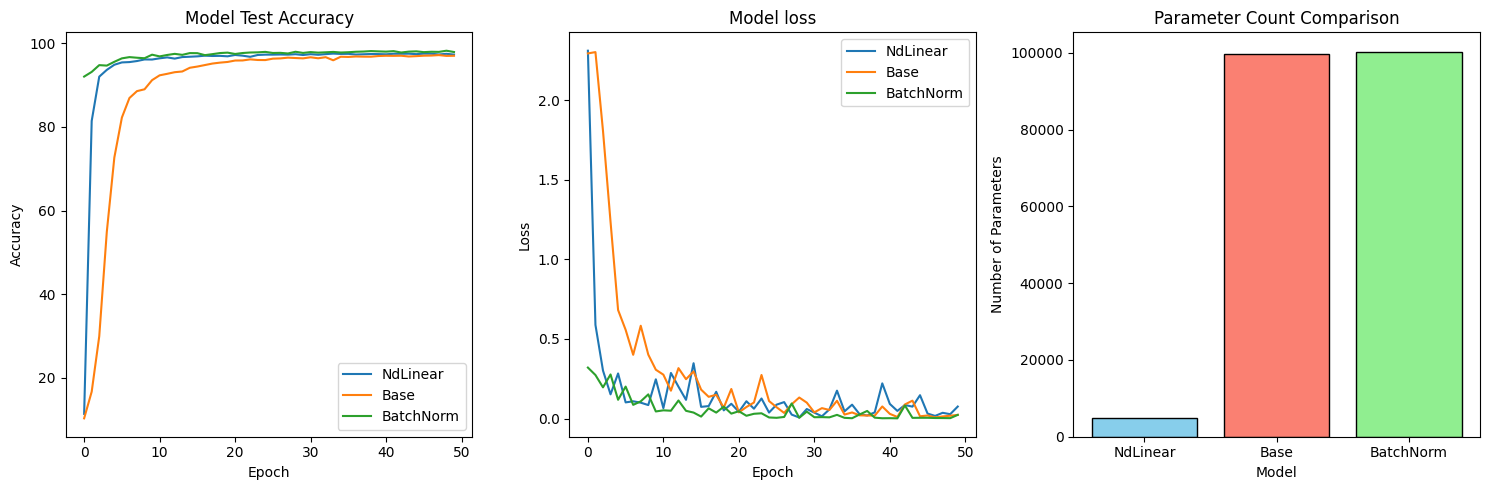

In [69]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Accuracy curves
ax1.plot(accuracy_history_nd, label='NdLinear')
ax1.plot(accuracy_history_base, label='Base')
ax1.plot(accuracy_history_BN, label='BatchNorm')
ax1.set_title('Model Test Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

ax2.plot(loss_history_nd)
ax2.plot(loss_history_base)
ax2.plot(loss_history_BN)
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['NdLinear','Base','BatchNorm'], loc='upper right')

models = ['NdLinear','Base','BatchNorm']
params = [params_nd,params_base,params_BN ]
colors = ['skyblue', 'salmon', 'lightgreen']

ax3.bar(models, params, color=colors, edgecolor='black')
ax3.set_title('Parameter Count Comparison')
ax3.set_ylabel('Number of Parameters')
ax3.set_xlabel('Model')

plt.tight_layout()
plt.show()


In [43]:
def get_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        return torch.cuda.max_memory_allocated() / (1024 ** 2)  # MB
    return 0

models = {
    'NdLinear': model_ndlinear.to(device),
        'Base': model_base.to(device),
    'BatchNorm': model_BN.to(device),
}

# Create tensors and normalize data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = torch.tensor(train_images / 255.0, dtype=torch.float32).unsqueeze(-1)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_images = torch.tensor(test_images / 255.0, dtype=torch.float32).unsqueeze(-1)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for name, model in models.items():
    torch.cuda.reset_peak_memory_stats()  # Reset before measurement

    for images, _ in train_loader:
        images = images.to(device)
        _ = model(images)

    print(f"{name} GPU memory: {get_gpu_memory():.2f} MB")

NdLinear GPU memory: 22.69 MB
Base GPU memory: 21.86 MB
BatchNorm GPU memory: 21.17 MB


In [42]:
# Time one epoch for each model
for name, model in models.items():
    start_time = time.time()

    # Run one epoch
    model.train()
    for images, _ in train_loader:  # Use your existing train_loader
        images = images.to(device)
        outputs = model(images)  # Forward pass

    end_time = time.time()
    print(f"{name}: {end_time - start_time:.2f} seconds per epoch")

NdLinear: 1.47 seconds per epoch
Base: 0.92 seconds per epoch
BatchNorm: 1.24 seconds per epoch


In [58]:
# Inference speed

for name, model in models.items():
      start = time.time()
      for images, _ in test_loader:
          images = images.to(device)
          _ = model(images)
      print(f"{name} Inference Speed: {(time.time()-start):.2f}s")

NdLinear Inference Speed: 0.28s
Base Inference Speed: 0.16s
BatchNorm Inference Speed: 0.20s


In [62]:
def get_model_size_mb(model):
    # Calculate total parameters in bytes (float32 = 4 bytes per param)
    param_size = sum(p.numel() * 4 for p in model.parameters())
    # Convert to MB
    return param_size / (1024 ** 2)

print(f"NdLinear model size: {get_model_size_mb(model_ndlinear):.2f} MB")
print(f"Base model size: {get_model_size_mb(model_base):.2f} MB")
print(f"BatchNorm model size: {get_model_size_mb(model_BN):.2f} MB")

NdLinear model size: 0.02 MB
Base model size: 0.38 MB
BatchNorm model size: 0.38 MB


**Model Performance Comparison**

| Metric               | NdLinear       | Base Model     | BatchNorm Model |
|----------------------|---------------|---------------|-----------------|
| **GPU Memory**       | 22.69 MB      | 21.86 MB      | 21.17 MB        |
| **Training Speed/Epoch** | 1.47 s     | 0.92 s        | 1.24 s          |
| **Inference Speed**  | 0.28 s        | 0.16 s        | 0.20 s          |
| **Achieves >90% accuracy** | 3 epochs | 10 epochs | 1 epoch
|
| **Model Size**       | 0.02 MB       | 0.38 MB       | 0.38 MB         |

As we can see the NdLinear model performance is very close overall to the Batch Normalization model. It gets over 90% of accuracy more than three times faster than the Base model. Where it clearly outperforms both models is in the model size, being 95% smaller than the other two models.

Considering how much models can grow and that in terms of accuracy and training epochs it outperformed the base model, we can see the motivation to use this layer.

*María Victoria Liendro*